In [ ]:
#|default_exp local_distance_scaling
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

# 3h1 Local Distance Scaling
> Scaling comparison spaces to match the manifold

With the curvature-agnostic kernel, we saw that adapting the kernel bandwidth solely based on the *nearest* neighbor distance -- and then scaling this appropriately to change the bandwidth -- allows better comparison between spaces of differing curvatures. The local Euclidean distances are what we trust most: so use them.

However, it might be desirable to further separate the *bandwidth of the kernel* from the scale of the comparison space. Presently the kernel is scaled only to make it comparable between spaces, in a way that makes it hard to compare across densities or dimensions. But if the *comparison space* is pre-scaled to match local distances, than one can use a consistent kernel bandwidth across dimensions/densities.

The biggest question is how to measure these local distances.
Here are some options:

1. Measure average distance to nearest neighbor, then scale entire dataset by that. Verify that after scaling in this way, these measures are the same.

**Hypothesis**: Scaling the *average local distance* of the Euclidean comparison to match that of given manifold will allow direct usage of the fixed kernel in both spaces.

# Machinery

In [ ]:
#|export
import jax.numpy as jnp
from sklearn.metrics import pairwise_distances
from fastcore.all import *

# def partition_by_row(arr, k):
#     return jnp.apply_along_axis(lambda x: jnp.partition(x, k), arr=arr, axis=1)

def get_average_local_distances(X, k = 1):
    D = pairwise_distances(X)
    nearest_distances = jnp.partition(D, k, axis = 1)[:,k]
    average_nearest_distances = jnp.median(nearest_distances)
    return  average_nearest_distances, nearest_distances

def scale_by_local_distances(X_manifold, X_comparison, k = 1):
    m_average_nearest_distances, m_nearest_distances = get_average_local_distances(X_manifold, k = k)
    c_average_nearest_distances, c_nearest_distances = get_average_local_distances(X_comparison, k = k)
    
    distance_ratio = m_average_nearest_distances / c_average_nearest_distances
    
    return X_comparison * distance_ratio

# Results

## Quick Verification
Does it actually scale the distances correctly?

In [ ]:
X, ks = torus(3000)
X_euc = plane(3000, dim=2)

In [ ]:
avg_dists, local_dists = get_average_local_distances(X)

In [ ]:
avg_dists

Array(0.07636365, dtype=float32)

In [ ]:
avg_dists_E, local_dists_E = get_average_local_distances(X_euc)

In [ ]:
avg_dists_E

Array(0.01732921, dtype=float32)

In [ ]:
X_euc_scaled = scale_by_local_distances(X, X_euc)

In [ ]:
avg_dists_E_scaled, local_dists_E_scaled = get_average_local_distances(X_euc_scaled)

In [ ]:
avg_dists_E_scaled

Array(0.07636353, dtype=float32)

In [ ]:
assert (avg_dists_E_scaled - avg_dists) < 1e-3

In [ ]:
local_dists

Array([0.11646127, 0.12184224, 0.14785296, ..., 0.11011303, 0.14482935,
       0.06373855], dtype=float32)

In [ ]:
jnp.mean(local_dists)

Array(0.08047482, dtype=float32)

In [ ]:
D = pairwise_distances(X)
nearest_distances = jnp.partition(D, 1)

In [ ]:
nearest_distances

Array([[0.        , 0.02848139, 4.1101274 , ..., 0.236892  , 0.15368675,
        0.13540652],
       [0.        , 0.13367437, 5.9541707 , ..., 0.15534642, 0.15386489,
        0.15026806],
       [0.        , 0.04639063, 5.987613  , ..., 0.18057321, 0.1703479 ,
        0.0869346 ],
       ...,
       [0.        , 0.02384915, 5.7134714 , ..., 0.23140664, 0.22077109,
        0.17865753],
       [0.        , 0.07773162, 4.6060452 , ..., 0.1635677 , 0.12848423,
        0.11227523],
       [0.        , 0.05679626, 5.0465126 , ..., 0.20522955, 0.20262152,
        0.1383807 ]], dtype=float32)

In [ ]:
nearest_distances

Array([0.        , 0.13367437, 5.9541707 , ..., 0.15534642, 0.15386489,
       0.15026806], dtype=float32)

In [ ]:
plot_3d(X, local_dists, use_plotly=True)

(array([215., 568., 732., 635., 392., 263., 113.,  54.,  21.,   7.]),
 array([0.00197508, 0.02663229, 0.05128951, 0.07594672, 0.10060393,
        0.12526114, 0.14991835, 0.17457557, 0.19923277, 0.22388999,
        0.2485472 ]),
 <BarContainer object of 10 artists>)

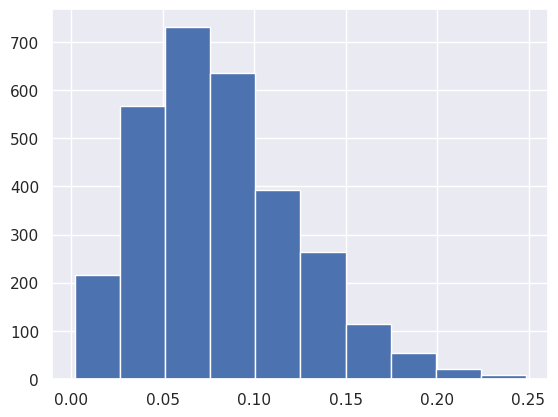

In [ ]:
plt.hist(local_dists)

## Toy Dataset Verification
Does it pick up curvature in 2d?

In [73]:
from diffusion_curvature.core import *
graph_former = partial(get_adaptive_graph,k=5, alpha=1)
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Scaled Fixed",
    comparison_method="Subtraction"
)

In [88]:
X, ks = torus(n = 2000)
regular_plane = plane(n = 2000, dim = 2)
G = graph_former(X)
G_plane = graph_former(regular_plane)

2024-05-17 11:08:39,437:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-05-17 11:08:39,755:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


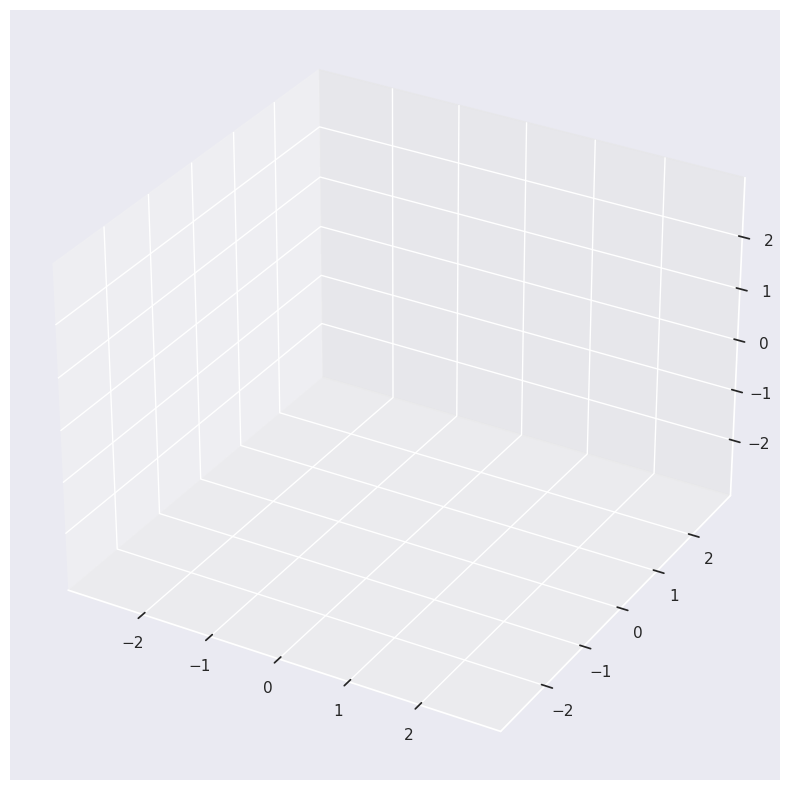

In [75]:
ks = DC.fit_transform(G, dim = 2, t = 25, X = X)
plot_3d(X,ks)

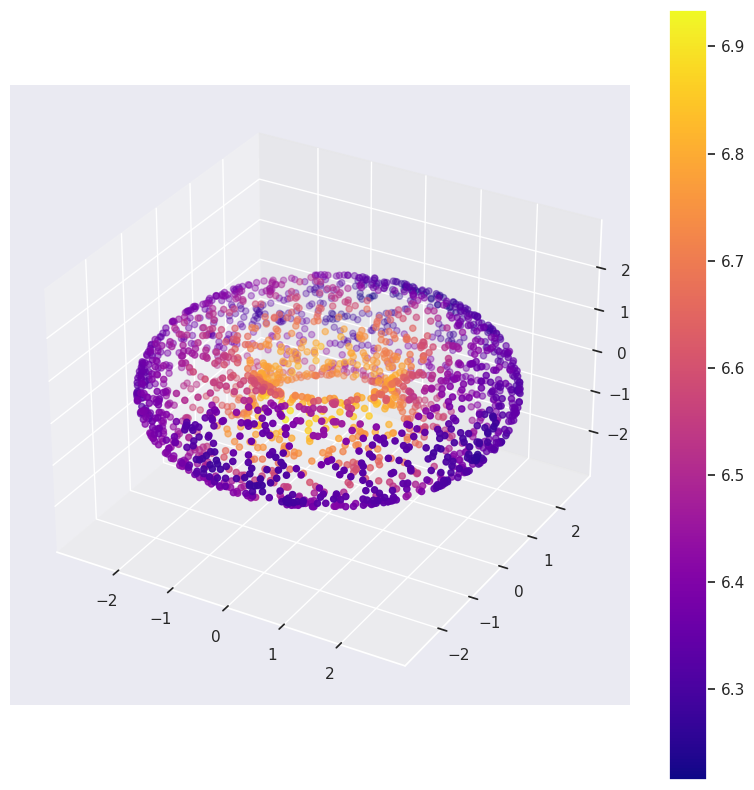

In [95]:
ks_m = DC.unsigned_curvature(G, t = 25)
plot_3d(X, ks_m, colorbar = True)

In [77]:
G_e = graph_former(DC.Rd)

2024-05-17 11:06:07,996:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [80]:
ks_euc = DC.unsigned_curvature(G_e, t = 25)

In [91]:
ks_regular_plane = DC.unsigned_curvature(G_plane, t = 25)

In [102]:
ksr = ks_euc[0] - ks_m

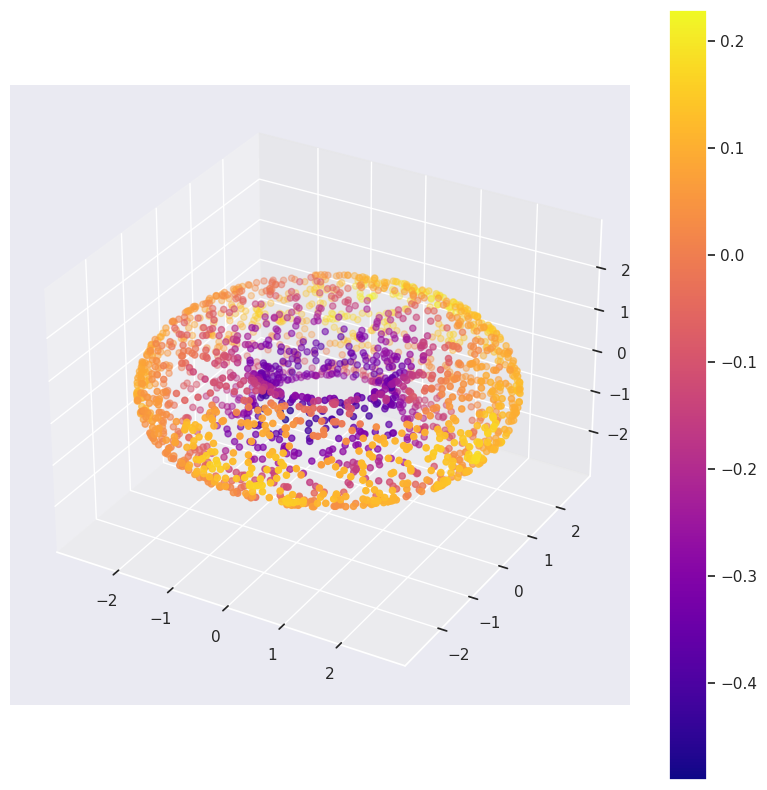

In [103]:
plot_3d(X, ksr, colorbar=True)

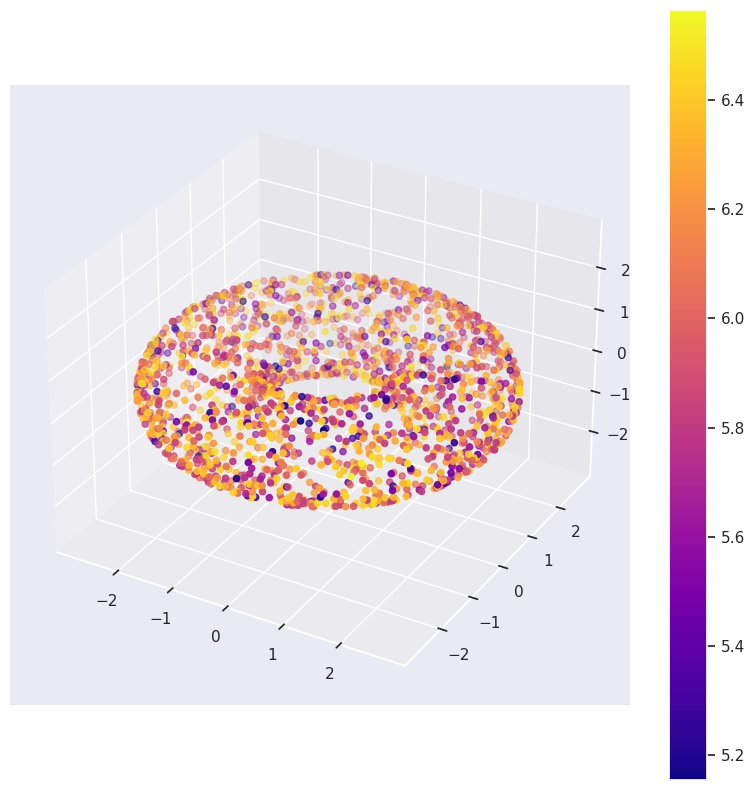

In [97]:
plot_3d(X, ks_regular_plane, colorbar=True)

In [69]:
ks

Array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

# Conclusion